# *학습 관련 기술들*

## 4. 바른 학습을 위해

- 기계학습에서는 오버피팅이 문제가 되는 경우가 많으며, 이를 억제하는 기술이 중요
___

### 1) 오버피팅
- 오버피팅은 주로 다음 두 경우에 발생
> - 매개변수가 많고 표현력이 높은 모델
> - 훈련 데이터가 적은 경우

- 의도적으로 오버피팅을 발생시키기 위해 훈련 데이터를 300/60,000개 사용하고 7층 네트워크를 사용
- 각 층 뉴런은 100개, 활성화 함수는 ReLU 사용, 학습 방법은 Adam 시도

In [3]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from data.mnist import load_mnist
from data.multi_layer_net import MultiLayerNet
from data.optimizer import SGD
from data.optimizer import Adam
from data.optimizer import AdaGrad
from data.trainer import Trainer

- 원하는 데이터만 추출 (1~300번)

In [4]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

- 아래와 같이 기본 세팅 설정 (network구성, weight decay, 학습방법 설정, batch/epochs 구성 등)

In [16]:
# weight decay（가중치 감쇠） 설정 =======================
weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
#weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

- max_epochs까지 for문 수행

In [18]:
for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        if i % (iter_per_epoch*10) == 0:
            print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


epoch:0, train acc:0.09, test acc:0.1057
epoch:10, train acc:0.38333333333333336, test acc:0.2858
epoch:20, train acc:0.51, test acc:0.3732
epoch:30, train acc:0.7566666666666667, test acc:0.5631
epoch:40, train acc:0.84, test acc:0.6549
epoch:50, train acc:0.8766666666666667, test acc:0.6826
epoch:60, train acc:0.9033333333333333, test acc:0.7031
epoch:70, train acc:0.9433333333333334, test acc:0.7185
epoch:80, train acc:0.9666666666666667, test acc:0.7179
epoch:90, train acc:0.9866666666666667, test acc:0.7321
epoch:100, train acc:0.9966666666666667, test acc:0.7369
epoch:110, train acc:0.9966666666666667, test acc:0.7415
epoch:120, train acc:1.0, test acc:0.7432
epoch:130, train acc:1.0, test acc:0.7481
epoch:140, train acc:1.0, test acc:0.7495
epoch:150, train acc:1.0, test acc:0.7499
epoch:160, train acc:1.0, test acc:0.7546
epoch:170, train acc:1.0, test acc:0.7526
epoch:180, train acc:1.0, test acc:0.7514
epoch:190, train acc:1.0, test acc:0.753
epoch:200, train acc:1.0, test ac

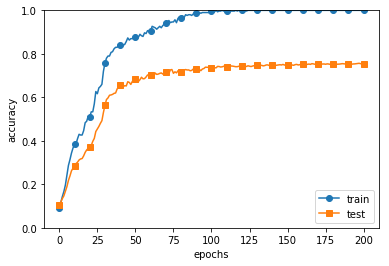

In [19]:
# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

- 위의 그래프에서 볼 수 있듯이 train 데이터에서의 정확도가 100에폭부터 거의 100%에 근사하는 반면, test데이터에서의 정확도간에 큰 오차 발생
- 위같은 사례를 오버피팅이라고 볼 수 있음
___

### 2) 가중치 감소

- 오버피팅 방지를 위해 **weight decay(가중치 감소)**가 가장 빈번하게 사용됨

- 오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많기 때문에 큰 가중치에 상응하는 패널티를 부과하여 오버피팅 억제를 시도 (panelty)

> ### Recap
> - 신경망 학습의 목적은 손실함수 값 최소화
- 따라서 가중치의 L2 norm(제곱 norm)을 손실함수에 더하며 가중치가 커지느 것을 억제 가능
- L2 norm에 따른 가중치 감소는 $\frac{1}{2}\lambda W^2$가 됨
- 여기서 $\lambda$는 하이퍼파라미터로 패널티 규모를 설정, 앞쪽의 $\frac{1}{2}$는 미분 결과인 $\lambda W$를 조정하는 역할의 상수
- 가중치 감소는 모든 가중치의 손실함수에 $\frac{1}{2}\lambda W^2$를 더하며, 기울기 계산 시 정규화 항을 미분한 $\lambda W$를 더함
___
- $W = (w_1, w_2, w_3, ... , w_n)$일 때
- L2 norm $= \sqrt{w_1^2 + w_2^2 + w_3^2 + ... + w_n^2}$ 이며,
- L1 norm $ = \lvert w_1^2 \rvert + \lvert w_2^2 \rvert + \lvert w_3^2 \rvert + ... +\lvert w_n^2 \rvert$ 로 표현 가능

- 위 실험에서 weight decay를 적용하여 $\lambda = 0.1$로 재실험하면 아래와 같은 결과 기대

In [23]:
# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

In [24]:
for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        if i % (iter_per_epoch*10) == 0:
            print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            print('finish')
            break


epoch:0, train acc:0.15333333333333332, test acc:0.1076
epoch:10, train acc:0.34, test acc:0.2143
epoch:20, train acc:0.5066666666666667, test acc:0.3568
epoch:30, train acc:0.5766666666666667, test acc:0.4238
epoch:40, train acc:0.6433333333333333, test acc:0.4916
epoch:50, train acc:0.6966666666666667, test acc:0.5448
epoch:60, train acc:0.8033333333333333, test acc:0.6111
epoch:70, train acc:0.8266666666666667, test acc:0.6421
epoch:80, train acc:0.85, test acc:0.6713
epoch:90, train acc:0.8566666666666667, test acc:0.6781
epoch:100, train acc:0.8733333333333333, test acc:0.6958
epoch:110, train acc:0.9033333333333333, test acc:0.7029
epoch:120, train acc:0.8933333333333333, test acc:0.7056
epoch:130, train acc:0.89, test acc:0.7117
epoch:140, train acc:0.9, test acc:0.7223
epoch:150, train acc:0.9133333333333333, test acc:0.7298
epoch:160, train acc:0.93, test acc:0.7317
epoch:170, train acc:0.9266666666666666, test acc:0.7234
epoch:180, train acc:0.9233333333333333, test acc:0.736

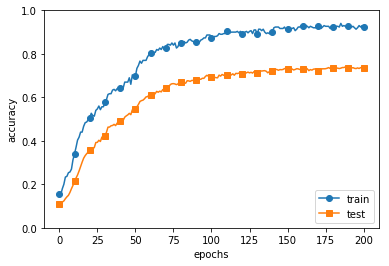

In [25]:
# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

- 주목할 점은 2가지 정도임
> 1) training과 test set 결과 간의 오차율이 줄어듬
>
> 2) 전체적인 정확도가 100%에 도달하지 못함

___

### 3) 드롭아웃

- Weight decay 방식은 간단하게 구현 가능학고 지나친 학습을 억제할 수 있음
- 하지만 신경망 모델이 복잡해질수록 가중치 감소만으로는 대응하기 어려워짐
- 이때 사용 가능한 방식이 **drop out(드롭아웃)**이며, 뉴런을 임의로 삭제하면서 학습하는 방식임
![](image/fig 6-22.png)

In [1]:
class Dropout:
    def __init__(self, dropout_ratio = 0.5):
        self.droupout_ratio = droupout_ratio
        self.mask = None
    
    
    def forward(self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1 - self.dropout_ratio)
    
    
    def backward(self, dout):
        return dout * self.mask

- self.mask에서 x와 형상이 같은 $N(0,1)$배열을 무작위로 생성하고 그 값이 dropout_ratio보다 큰 원소만 True로 설정
- 역전파때에도 마찬가지로 순전파 때 통과시킨 뉴런만 신호를 통과

In [8]:
from data.trainer import Trainer
from data.multi_layer_net_extend import MultiLayerNetExtend

In [11]:
# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

train loss:2.28163311973376
=== epoch:1, train acc:0.16, test acc:0.1569 ===
train loss:2.29288194527247
train loss:2.3039861237645685
train loss:2.2838216934298776
=== epoch:2, train acc:0.16666666666666666, test acc:0.1586 ===
train loss:2.276608398487763
train loss:2.2884841764398023
train loss:2.2659067073331944
=== epoch:3, train acc:0.17333333333333334, test acc:0.1631 ===
train loss:2.2894632546146987
train loss:2.2720651687977225
train loss:2.28098284036297
=== epoch:4, train acc:0.17333333333333334, test acc:0.1639 ===
train loss:2.290352595075366
train loss:2.286517771194532
train loss:2.302293150397212
=== epoch:5, train acc:0.17333333333333334, test acc:0.1668 ===
train loss:2.297776030228622
train loss:2.2931662879667942
train loss:2.2807370340601407
=== epoch:6, train acc:0.18, test acc:0.1692 ===
train loss:2.275454284511495
train loss:2.2882898587316287
train loss:2.291890829955229
=== epoch:7, train acc:0.17333333333333334, test acc:0.1683 ===
train loss:2.296813692432

=== epoch:57, train acc:0.3, test acc:0.2638 ===
train loss:2.2162317770034248
train loss:2.2134151806972526
train loss:2.1967698671288396
=== epoch:58, train acc:0.31666666666666665, test acc:0.2759 ===
train loss:2.197101142303516
train loss:2.16478275186079
train loss:2.1866392372864225
=== epoch:59, train acc:0.31, test acc:0.2723 ===
train loss:2.183957715156324
train loss:2.1955221773431464
train loss:2.1938404195104706
=== epoch:60, train acc:0.30666666666666664, test acc:0.2662 ===
train loss:2.175483270775972
train loss:2.1976414927724215
train loss:2.221481373921462
=== epoch:61, train acc:0.3, test acc:0.2627 ===
train loss:2.206603859342078
train loss:2.176008090395337
train loss:2.2196272659045384
=== epoch:62, train acc:0.30666666666666664, test acc:0.2666 ===
train loss:2.159807870248863
train loss:2.20257758766022
train loss:2.1772874957331334
=== epoch:63, train acc:0.2966666666666667, test acc:0.2632 ===
train loss:2.1632658628227897
train loss:2.196642967167897
train

=== epoch:113, train acc:0.39666666666666667, test acc:0.3302 ===
train loss:2.0174568863128504
train loss:2.0356795584419753
train loss:2.0803340910583072
=== epoch:114, train acc:0.4033333333333333, test acc:0.3351 ===
train loss:2.011349502019848
train loss:2.018937144616902
train loss:2.0326310504458216
=== epoch:115, train acc:0.41, test acc:0.3389 ===
train loss:2.047328225197366
train loss:2.000564268287219
train loss:1.9986456152395076
=== epoch:116, train acc:0.4166666666666667, test acc:0.3392 ===
train loss:2.0353856971909066
train loss:1.9617442809447323
train loss:1.9730737682639283
=== epoch:117, train acc:0.4066666666666667, test acc:0.3391 ===
train loss:2.0811904999603286
train loss:1.9982454148194202
train loss:1.9099551853421044
=== epoch:118, train acc:0.4033333333333333, test acc:0.3353 ===
train loss:2.038119534073546
train loss:2.0336024471390846
train loss:2.0772688778851127
=== epoch:119, train acc:0.4066666666666667, test acc:0.341 ===
train loss:2.01288323439

=== epoch:168, train acc:0.52, test acc:0.4057 ===
train loss:1.8003172265230674
train loss:1.6815483025488365
train loss:1.6735996692510475
=== epoch:169, train acc:0.5133333333333333, test acc:0.4054 ===
train loss:1.7139808928372482
train loss:1.6806684685467657
train loss:1.5725720234132057
=== epoch:170, train acc:0.52, test acc:0.4071 ===
train loss:1.6369675505039851
train loss:1.710309129842666
train loss:1.6567477135311115
=== epoch:171, train acc:0.5233333333333333, test acc:0.4107 ===
train loss:1.6622682870175587
train loss:1.7759498797837028
train loss:1.718624040327122
=== epoch:172, train acc:0.5266666666666666, test acc:0.4121 ===
train loss:1.6670827730453175
train loss:1.6568479156071407
train loss:1.6866081055390252
=== epoch:173, train acc:0.5233333333333333, test acc:0.4162 ===
train loss:1.6254421433293542
train loss:1.7294116883201434
train loss:1.7017453618407663
=== epoch:174, train acc:0.5333333333333333, test acc:0.4168 ===
train loss:1.6394201375747877
train

=== epoch:224, train acc:0.6033333333333334, test acc:0.4841 ===
train loss:1.260534067452019
train loss:1.3072570249325093
train loss:1.2039441132786872
=== epoch:225, train acc:0.6066666666666667, test acc:0.48 ===
train loss:1.3115046390432423
train loss:1.2328004046555459
train loss:1.197269355913586
=== epoch:226, train acc:0.6133333333333333, test acc:0.482 ===
train loss:1.3028992969701787
train loss:1.3848512261452997
train loss:1.346403689089225
=== epoch:227, train acc:0.6133333333333333, test acc:0.4867 ===
train loss:1.2894764138583235
train loss:1.2489315096847553
train loss:1.1456019039847485
=== epoch:228, train acc:0.61, test acc:0.4885 ===
train loss:1.254796383711233
train loss:1.2716447601013807
train loss:1.3011615873467413
=== epoch:229, train acc:0.6133333333333333, test acc:0.4907 ===
train loss:1.2749173653056787
train loss:1.4210568036503546
train loss:1.2900441982752366
=== epoch:230, train acc:0.63, test acc:0.4968 ===
train loss:1.195837920272514
train loss:

=== epoch:279, train acc:0.6933333333333334, test acc:0.5354 ===
train loss:1.086554760445063
train loss:0.9647415055753445
train loss:0.9400381887457228
=== epoch:280, train acc:0.6866666666666666, test acc:0.536 ===
train loss:1.0233592879785156
train loss:0.9806431969607542
train loss:1.0381082824801733
=== epoch:281, train acc:0.69, test acc:0.5392 ===
train loss:1.0502998423690673
train loss:1.0828810307089956
train loss:1.0022427706995731
=== epoch:282, train acc:0.69, test acc:0.5408 ===
train loss:1.072790581058976
train loss:0.9875106192083267
train loss:1.012049338407988
=== epoch:283, train acc:0.69, test acc:0.5395 ===
train loss:0.9571941344955996
train loss:0.9550036301161553
train loss:1.058107230751862
=== epoch:284, train acc:0.6866666666666666, test acc:0.5335 ===
train loss:1.1841149357086622
train loss:0.851664332210331
train loss:0.966547979457679
=== epoch:285, train acc:0.6766666666666666, test acc:0.5308 ===
train loss:1.0218512541679767
train loss:1.00825460563

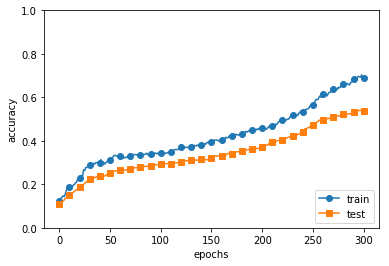

In [10]:
# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

- Drop out 적용 시 정확도가 감소하긴 하지만, 훈련 데이터와 시험 데이터 간의 차이가 감소
- Drop out은 batch 마다 뉴런을 무작위로 삭제하며 매번 다른 모델을 학습시키는 것으로 해석가능하며, 결과적으로 **앙상블학습과 유사**